# Simple Linear Regression with `statsmodels`

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import gauss, seed
from scipy import stats
import seaborn as sns
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from lin_reg import best_line

%matplotlib inline

## Objectives

- Explain and use the concepts of covariance and correlation
- Explain how to use `statsmodels` to construct linear regressions
- Explain how to interpret linear regressions

## Simple Linear Regression

### Covariance and Correlation

The idea of _correlation_ is the simple idea that variables often change _together_. For a simple example, cities with more buses tend to have higher populations.

We might observe that, as one variable X increases, so does another Y, OR that as X increases, Y decreases.

The _covariance_ describes how two variables co-vary. Note the similarity in the definition to the definition of ordinary variance:

#### Covariance

For two variables $X$ and $Y$, each with $n$ values:

$\Large\sigma_{XY} = \frac{\Sigma^n_{i = 1}(x_i - \mu_x)(y_i - \mu_y)}{n}$ <br/>

In [4]:
X = [1, 3, 5]
Y = [2, 9, 10]

In [5]:
# Covariance by hand:
((1-3) * (2-7) + (3-3) * (9-7) + (5-3) * (10-7)) / 3

5.333333333333333

In [6]:
# Better yet: With NumPy:
np.cov(X, Y, ddof=0)

array([[ 2.66666667,  5.33333333],
       [ 5.33333333, 12.66666667]])

What are these different numbers? What does `np.cov()` return?

In [7]:
np.cov(X, Y, ddof=0)[1, 0]

5.333333333333333

<details>
    <summary>Answer</summary>
`np.cov()` returns a covariance *matrix*: variances of individual variables down the main diagonal and covariances of the relevant variables off the main diagonal.
</details>

In [8]:
np.var(X)

2.6666666666666665

In [9]:
np.var(Y)

12.666666666666666

Note that the value of the covariance is very much a function of the values of X and Y, which can make interpretation difficult. What is often wanted is a _standardized_ scale for covariance, hence: _correlation_.

#### Correlation

Pearson Correlation:<br/>$\Large r_P = \frac{\Sigma^n_{i = 1}(x_i - \mu_x)(y_i - \mu_y)}{\sqrt{\Sigma^n_{i = 1}(x_i - \mu_x)^2\Sigma^n_{i = 1}(y_i -\mu_y)^2}}$

Note that we are simply standardizing the covariance by the standard deviations of X and Y (the $n$'s cancel!).

$\bf{Check}$:

<details><summary>
What happens if X = Y?
</summary>
Then numerator = denominator and the correlation = 1!
</details>
<br/>
We'll always have 
-1 <= r <= 1
(This was the point of standardizing by the standard deviations of X and Y.)

A correlation of -1 means that X and Y are perfectly negatively correlated, and a correlation of 1 means that X and Y are perfectly positively correlated.

NumPy also has a correlation method:

In [10]:
np.corrcoef(X, Y)

array([[1.        , 0.91766294],
       [0.91766294, 1.        ]])

In [11]:
np.corrcoef(X, Y)[0, 1] == (np.cov(X, Y, ddof=0) / (np.std(X) * np.std(Y)))[0, 1]

True

In [12]:
(np.cov(X, Y, ddof=0) / (np.std(X) * np.std(Y)))[0, 1]

0.917662935482247

And so does SciPy:

In [13]:
stats.pearsonr(X, Y)

PearsonRResult(statistic=0.9176629354822469, pvalue=0.26014693829300645)

In [14]:
# Pandas as well
df = pd.DataFrame([[1, 2], [3, 9], [5, 10]])

In [15]:
df

,0,1
0,1,2
1,3,9
2,5,10


In [16]:
df.corr()

,0,1
0,1.000000,0.917663
1,0.917663,1.000000


### Causation

_Why_ does it happen that variables correlate? It _may_ be that one is the cause of the other. A city having a high population, for example, probably does have some causal effect on the number of buses that the city has. But this _need not_ be the case, and that is why statisticians are fond of saying that 'correlation is not causation'. An alternative possibility, for example, is that high values of X and Y are _both_ caused by high values of some third factor Z. The size of children's feet, for example, is correlated with their ability to spell, but this is of course NOT because either is a cause of the other. Rather, BOTH are caused by the natural maturing and development of children. As they get older, both their feet and their spelling abilities grow!

### Statistical Learning Theory

It's important at this point to understand the distinction between dependent and independent variables.

Roughly, the independent variable is what can be directly manipulated and the dependent variable is what cannot be (but is nevertheless of great interest). What matters structurally is simply that we understand the dependent variable to be a _function_ of the independent variable(s).

This is the proper interpretation of a statistical _model_.

Simple idea: We can model correlation with a _line_. As one variable changes, so does the other.

This model has two *parameters*: *slope* and *y-intercept*.

Unless there's a perfectly (and suspiciously) linear relationship between our predictor(s) and our target, there will  be some sort of **error** or **loss** or **residual**. The best-fit line is constructed by minimizing the sum of the squares of these losses.

### Regression Equation

The solution for a simple regression best-fit line is as follows:

- slope: <br/>$\Large m = r_P\frac{\sigma_y}{\sigma_x} = \frac{cov(X, Y)}{var(X)}$

- y-intercept:<br/> $\Large b = \mu_y - m\mu_x$

#### Proof

<details>
    <summary>Click here</summary>

We demonstrate this by setting the derivative of the loss function, $\Sigma^n_{i=1}(y_i - (mx_i + b))^2$, equal to 0. **We shall see this calculus trick many times!**

For this purpose we consider the loss a function of its optimizing parameters $m$ and $b$. So there are therefore two partial derivatives to consider. (We'll cover this in more depth later in the course.)

(i) $\frac{\partial}{\partial b}[\sum^n_{i=1}(y_i - mx_i - b)^2] = -2\sum^n_{i=1}(y_i - mx_i - b)$

(ii) $\frac{\partial}{\partial m}[\sum^n_{i=1}(y_i - mx_i - b)^2] = -2\sum^n_{i=1}x_i\sum^n_{i=1}(y_i - mx_i - b)$

- Let's set the first to 0:

$-2\sum^n_{i=1}(y_i - mx_i - b) = 0$ <br/>
$\sum^n_{i=1}(y_i - mx_i) = \sum^n_{i=1}b = nb$ <br/>

**So:** $\large b = \frac{\sum^n_{i=1}(y_i - mx_i)}{n} = \mu_y - m\mu_x$

- Let's set the second to 0:

$-2\sum^n_{i=1}x_i\sum^n_{i=1}(y_i - mx_i - b) = 0$ <br/>
$\sum^n_{i=1}(x_iy_i - mx^2_i - bx_i) = 0$ <br/>

- Plugging in our previous result, we have:

$\sum^n_{i=1}x_iy_i - (\frac{1}{n}\sum^n_{i=1}y_i - \frac{m}{n}\sum^n_{i=1}x_i)\sum^n_{i=1}x_i - m\sum^n_{i=1}x^2_i = 0$ <br/>
$\sum^n_{i=1}x_iy_i - \frac{1}{n}\sum^n_{i=1}x_i\sum^n_{i=1}y_i + \frac{m}{n}(\sum^n_{i=1}x_i)^2 - m\sum^n_{i=1}x^2_i = 0$ <br/>

**So:** $\large m = \frac{\sum^n_{i=1}x_iy_i - \frac{1}{n}\sum^n_{i=1}x_i\sum^n_{i=1}y_i}{\sum^n_{i=1}x^2_i - \frac{1}{n}(\sum^n_{i=1}x_i)^2} = \frac{n\times(\frac{1}{n}\sum^n_{i=1}x_iy_i - \frac{1}{n^2}\sum^n_{i=1}x_i\sum^n_{i=1}y_i)}{n\times(\frac{1}{n}\sum^n_{i=1}x^2_i - \mu^2_x)} = \frac{cov(X, Y)}{var(X)}$

For more on the proof see [here](https://math.stackexchange.com/questions/716826/derivation-of-simple-linear-regression-parameters).
    
</details>

### Interpretation

The output of the simple linear regression algorithm is a pair of parameters: the slope and the y-intercept of the best-fit line through the data.

***I therefore have a (more or less crude) MODEL of the phenomenon in question:***

Suppose I have a bunch of data about (i) how many cigarettes people smoked in their lifetimes and (ii) how many years those same people lived. If I set my independent variable ("x") to be the number of cigarettes smoked and my dependent variable ("y") to be the number of years lived, then ***for any deceased person at all I will have a way of estimating the number of years that person lived if I know the number of cigarettes that that person smoked***. This estimate is exactly what the best-fit line gives me.

Suppose the parameters of the regression come out to be $\beta_0 = 100$ years and $\beta_1 = -1\times 10^{-4}$ years / cigarette ([in reality](https://www.medicalnewstoday.com/releases/9703#1) these are probably both a bit high).

Then we would be modeling the lifespan of human beings according to the number of cigarettes smoked:

$Y = \beta_1\times n + \beta_0$,

where $Y$ = the number of years (estimated) and $n$ is the number of cigarettes smoked.

- If someone smoked 0 cigarettes, then we would estimate that person's lifespan as:

$-1\times 10^{-4}\times 0 + 100 = 100$ years.

- If someone smoked a pack a day for 30 years, that's 20 * 365 * 30 = 219000 cigarettes (never mind about leap years!), so we would estimate that person's lifespan as:

$-1\times 10^{-4}\times 219000 + 100 = 78.1$ years.

### Using `best_line()`

Let's take a look at the code.

In [18]:
X, Y

([1, 3, 5], [2, 9, 10])

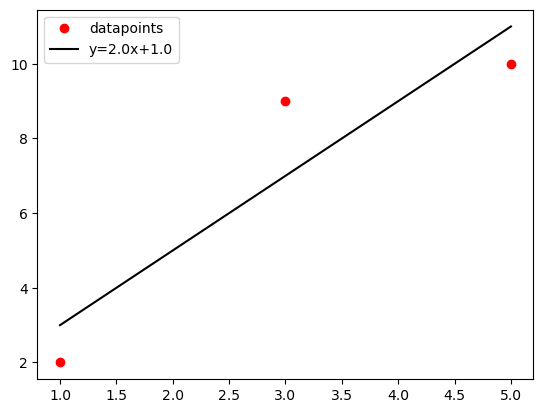

In [17]:
best_line(X, Y)

The best-fit line exists no matter what my data look like!

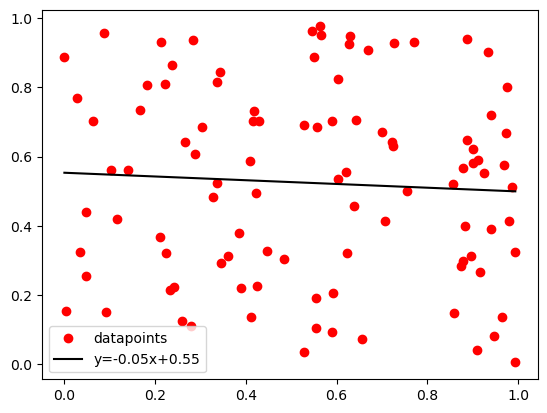

In [19]:
X_rand = stats.uniform.rvs(size=100)
Y_rand = stats.uniform.rvs(size=100)

best_line(X_rand, Y_rand)

Experiment: [Playing with regression line](https://www.desmos.com/calculator/jwquvmikhr)

## Visualization of Error

In [20]:
# Adjusting X so that the intercept term of the best-fit line will be 0
X = np.array([1.5, 3.5, 5.5])
Y = np.array([2, 9, 10])
X_plus_c = sm.add_constant(X)

In [22]:
X_plus_c

array([[1. , 1.5],
       [1. , 3.5],
       [1. , 5.5]])

In [32]:
model = sm.OLS(endog=Y, exog=X_plus_c).fit()

In [33]:
type(model)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [34]:
model.summary()

/Users/danielburdeno/miniconda3/envs/Cohort_Env/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     5.333
Date:                Thu, 17 Oct 2024   Prob (F-statistic):              0.260
Time:                        15:50:03   Log-Likelihood:                -5.2965
No. Observations:                   3   AIC:                             14.59
Df Residuals:                       1   BIC:                             12.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.776e-15      3.345  -5.31e-16      1.000     -42.499      42.499
x1             2.0000      0.866      2.309      0.260      -9.004      13.004
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                           0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         9.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
stats.pearsonr(X,Y)

PearsonRResult(statistic=0.9176629354822469, pvalue=0.26014693829300645)

In [38]:
model.summary().tables[1]

/Users/danielburdeno/miniconda3/envs/Cohort_Env/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


,coef,std err,t,P>|t|,[0.025,0.975]
const,-1.776e-15,3.345,-5.31e-16,1.000,-42.499,42.499
x1,2.0000,0.866,2.309,0.260,-9.004,13.004


In [39]:
model.predict(X_plus_c)

array([ 3.,  7., 11.])

In [40]:
X

array([1.5, 3.5, 5.5])

In [41]:
def sse(m):
    # sum of squared errors
    line = m*X
    err = sum(x**2 for x in [line - model.predict(X_plus_c)])
    return sum(err)

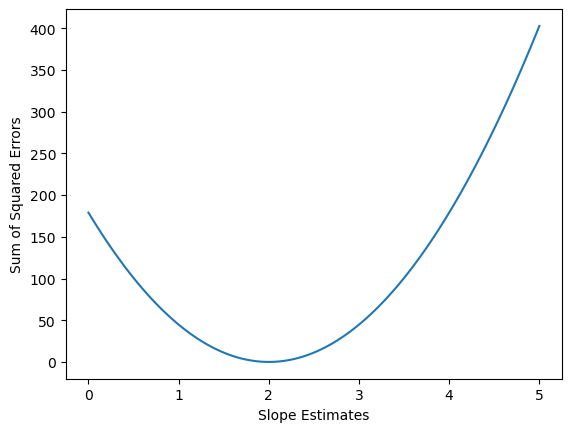

In [42]:
fig, ax = plt.subplots()

ms = np.linspace(0, 5, 100)
ys = [sse(m) for m in ms]

ax.set_xlabel('Slope Estimates')
ax.set_ylabel('Sum of Squared Errors')
ax.plot(ms, ys);

In [43]:
# Going 3d to plot error as a function of both m and b

def new_sse(m, x, b, y):
    """
    This function returns the sum of squared errors for
    a target y and a linear estimate mx + b.
    """
    return len(x) * metrics.mean_squared_error(y, m*x + b)

In [44]:
# Going back to our original example
X_sample = np.array([1, 3, 5])
Y_sample = np.array([2, 9, 10])

In [45]:
# This should be our minimum error
new_sse(2, X_sample, 1, Y_sample)

6.0

6.089276604428118
1.9494949494949498
2.05050505050505
6.004897459442912
0.9595959595959593


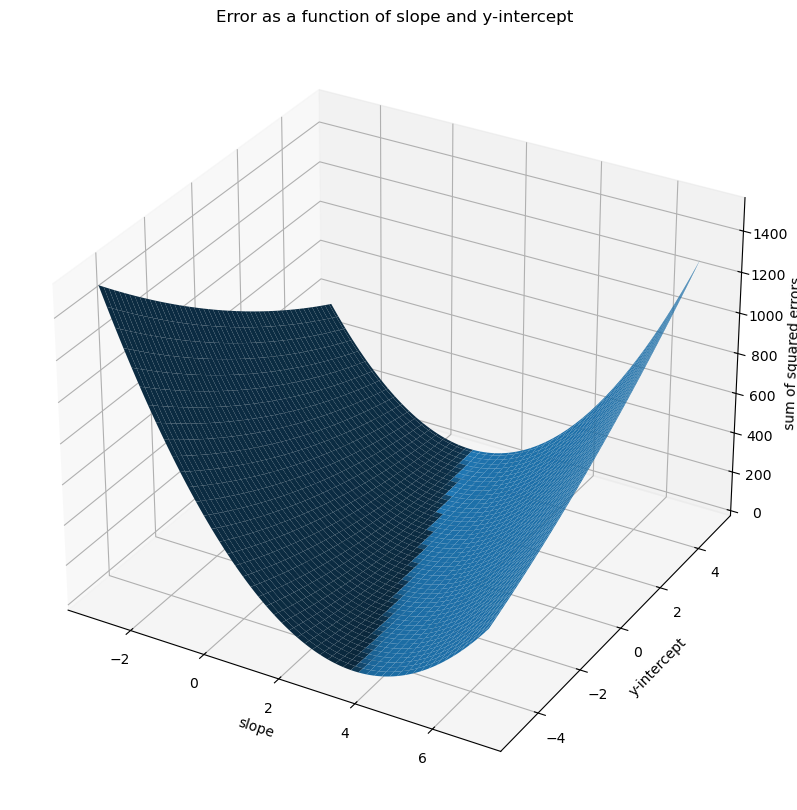

In [46]:
ms = np.linspace(-3, 7, 100)
bs = np.linspace(-5, 5, 100)

X_grid, Y_grid = np.meshgrid(ms, bs)

Z = np.array([[new_sse(m, X_sample, b, Y_sample) for m in ms] for b in bs])

m_errs = {}
for m in ms:
    m_errs[m] = new_sse(m, X_sample, 1, Y_sample)
print(min(m_errs.values()))
for k in m_errs:
    if m_errs[k] == min(m_errs.values()):
        print(k)

b_errs = {}
for b in bs:
    b_errs[b] = new_sse(2, X_sample, b, Y_sample)
print(min(b_errs.values()))
for k in b_errs:
    if b_errs[k] == min(b_errs.values()):
        print(k)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X_grid, Y_grid, Z)
ax.set_xlabel('slope')
ax.set_ylabel('y-intercept')
ax.set_zlabel('sum of squared errors')
plt.title('Error as a function of slope and y-intercept');
#plt.savefig('images/surfacePlotSSE')

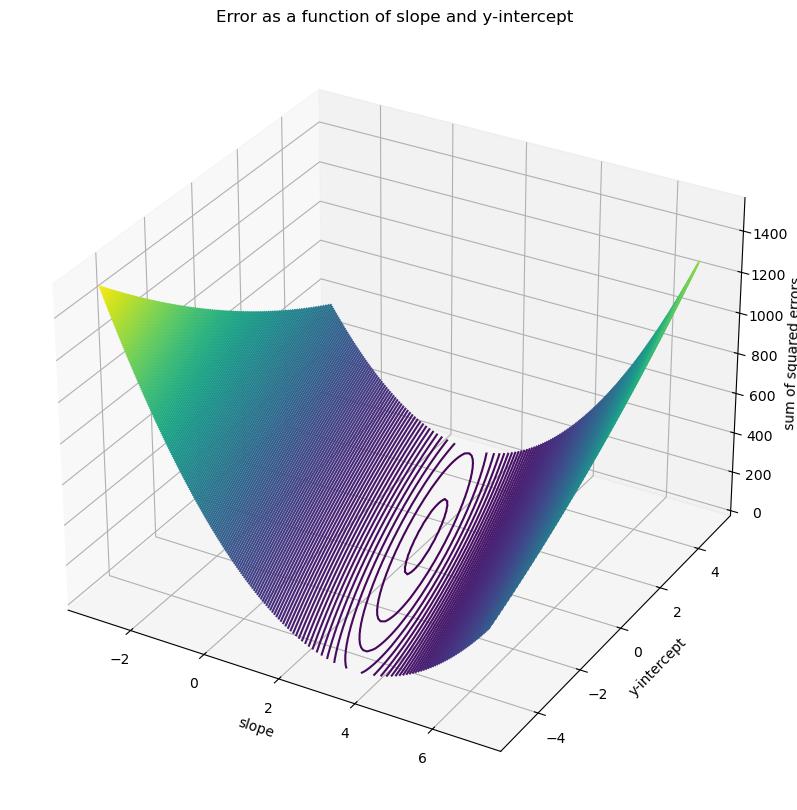

In [47]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.contour3D(X_grid, Y_grid, Z, 200)
ax.set_xlabel('slope')
ax.set_ylabel('y-intercept')
ax.set_zlabel('sum of squared errors')
plt.title('Error as a function of slope and y-intercept');
#plt.savefig('images/contourPlotSSE')

## Simple Linear Regression with `statsmodels`

Let's take a look at how to build a simple linear regression model with `statsmodels`. The `statsmodels` package offers a highly descriptive report of the fit of a regression model. Let's generate a simple regression and then analyze the report!

First let's try data that fit a straight line perfectly:

In [48]:
x = np.arange(20)
y = 3*x + 5

test_df = pd.DataFrame({'x': x, 'y':y})
test_df.head(10)

,x,y
0,0,5
1,1,8
2,2,11
3,3,14
4,4,17
5,5,20
6,6,23
7,7,26
8,8,29
9,9,32


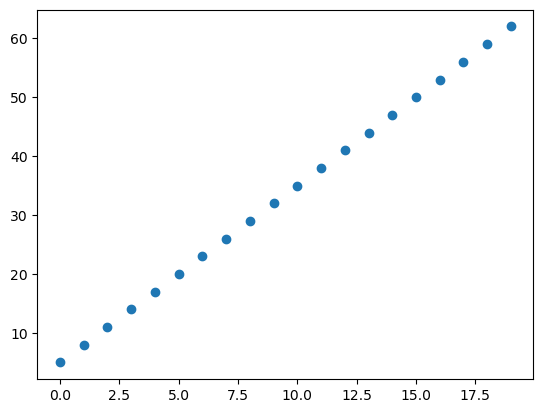

In [49]:
fig, ax = plt.subplots()
ax.scatter(x, y);

### Regression Without Error in `statsmodels`

The `statsmodels` OLS class API takes an endogenous (dependent) variable and an exogenous (independent) variable. We also want an intercept term, so we'll use the `add_constant()` function:

In [50]:
print("The data itself:\n", test_df['x'], '\n', '*'*64)
print("The data with an extra column of 1's:\n", sm.add_constant(test_df['x']))

The data itself:
 0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
Name: x, dtype: int64 
 ****************************************************************
The data with an extra column of 1's:
     const   x
0     1.0   0
1     1.0   1
2     1.0   2
3     1.0   3
4     1.0   4
5     1.0   5
6     1.0   6
7     1.0   7
8     1.0   8
9     1.0   9
10    1.0  10
11    1.0  11
12    1.0  12
13    1.0  13
14    1.0  14
15    1.0  15
16    1.0  16
17    1.0  17
18    1.0  18
19    1.0  19


Does this make sense?

Instead of setting up the regression $y$ ~ $x$, we're setting up $y$ ~ $x_1$ + $x_2$, where $x_2 = 1$ for all observations.

- **Without** the constant, we're looking for a parameter $\beta_1$ that minimizes the error around $y = \beta_1x$;
- **With** the constant, we're looking for two parameters $\beta_0$ and $\beta_1$ that minimize the error around $y = \beta_1x_1 + \beta_0x_2 = \beta_1x_1 + \beta_0$.

In [51]:
endog = test_df['y']
exog = sm.add_constant(test_df['x'])
lin_reg_model = sm.OLS(endog, exog)

In [52]:
type(lin_reg_model)

statsmodels.regression.linear_model.OLS

In [53]:
lin_reg_model.summary()

AttributeError: 'OLS' object has no attribute 'summary'

In [54]:
lin_reg_model.fit()

In [57]:
lin_model = lin_reg_model.fit()

We'll call the `.summary()` method on the fitted model object:

In [58]:
lin_model.summary()

/Users/danielburdeno/miniconda3/envs/Cohort_Env/lib/python3.12/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/danielburdeno/miniconda3/envs/Cohort_Env/lib/python3.12/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/danielburdeno/miniconda3/envs/Cohort_Env/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1580: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/danielburdeno/miniconda3/envs/Cohor

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.067e+32
Date:                Thu, 17 Oct 2024   Prob (F-statistic):          2.05e-278
Time:                        16:04:41   Log-Likelihood:                 623.18
No. Observations:                  20   AIC:                            -1242.
Df Residuals:                      18   BIC:                            -1240.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0000   3.23e-15   1.55e+15      0.000       5.000       5.000
x              3.0000    2.9e-16   1.03e+16      0.000       3.000       3.000
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         21.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regression with Error in `statsmodels`

Now let's add a little noise:

In [59]:
seed(42)

x = np.arange(20)
y = np.array([3*pt + 5 + gauss(mu=0, sigma=5) for pt in x])
y

array([ 4.27954835,  7.135482  , 10.44342069, 17.50991863, 16.36205858,
       12.51323293, 24.66159172, 24.66331261, 27.91520658, 32.57942393,
       36.16148868, 43.81779343, 44.28318253, 44.55253589, 43.30839199,
       44.92668816, 54.23171098, 62.55540414, 59.20828432, 61.46838353])

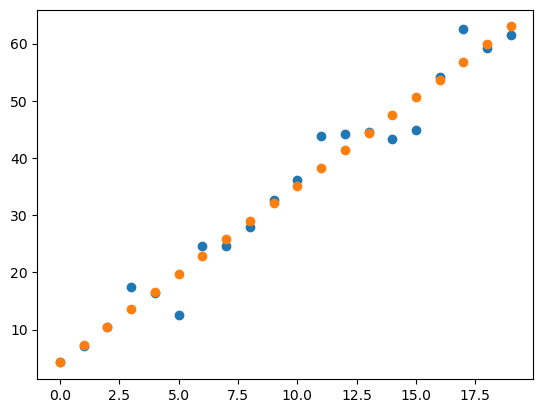

In [64]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.scatter(x, model.predict(sm.add_constant(x)));

In [61]:
model = sm.OLS(y, sm.add_constant(x)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     568.8
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           4.52e-15
Time:                        16:05:50   Log-Likelihood:                -51.457
No. Observations:                  20   AIC:                             106.9
Df Residuals:                      18   BIC:                             108.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2654      1.440      2.962      0.008       1.240       7.291
x1             3.0909      0.130     23.849      0.000       2.819       3.363
==============================================================================
Omnibus:                        1.113   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.573   Jarque-Bera (JB):                0.317
Skew:                          -0.292   Prob(JB):                        0.854
Kurtosis:                       3.196   Cond. No.                         21.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fitted Model Attributes and Methods

The fitted model has [many](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html) attributes and methods. I'll look at a couple here.

In [65]:
type(model)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [66]:
model.tvalues

array([ 2.96155659, 23.84931115])

In [67]:
model.pvalues

array([8.3546536e-03, 4.5234128e-15])

In [68]:
model.f_pvalue

4.523412802537715e-15

In [69]:
model.mse_total

344.9574120327555

In [71]:
model.mse_resid

11.169574843062227

The `.summary()` method returns a `Summary` object with lots of helpful information about the model.

In [72]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     568.8
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           4.52e-15
Time:                        16:10:38   Log-Likelihood:                -51.457
No. Observations:                  20   AIC:                             106.9
Df Residuals:                      18   BIC:                             108.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2654      1.440      2.962      0.008       1.240       7.291
x1             3.0909      0.130     23.849      0.000       2.819       3.363
==============================================================================
Omnibus:                        1.113   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.573   Jarque-Bera (JB):                0.317
Skew:                          -0.292   Prob(JB):                        0.854
Kurtosis:                       3.196   Cond. No.                         21.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
model.params

array([4.26541226, 3.0908885 ])

What are all these statistics!? Let's say a word about them.

## Betas and $p$-Values

Let's start with the second of the three tables that compose the model summary:

In [74]:
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,4.2654,1.440,2.962,0.008,1.240,7.291
x1,3.0909,0.130,23.849,0.000,2.819,3.363


What do we have here?

### coef

We have one row for our input variable ("x1") and another for our intercept term ("const"). The first column ("coef") shows us the betas themselves. Remember that we constructed our data by starting with our independent variable $X$ and then setting $Y = 3X + 5 + noise$. As we can see, the noise influenced the data enough to adjust the optimal $\beta_1$ to 3.0909 and the optimal $\beta_0$ to 4.2654.

What do these coefficients mean?

- The 3.0909 coefficient on x1 means that if we adjust x1 *by one unit*, our model will predict the corresponding y value to increase by 3.0909

- The 4.2654 coefficient on const means that our model's prediction will be 4.2654 for an *input of 0*.

In [75]:
# The input to the .predict() method takes a value both for const and for x1.
# The const value will always be 1 (since we want the model to calculate
# beta0*1 + beta1*x).

model.predict([1, 0])

array([4.26541226])

In [80]:
4.27 + 3.09 + 3.09

10.45

That's the value of $\beta_0$.

In [76]:
model.predict([1, 1])

array([7.35630076])

In [78]:
model.predict([1, 2])

array([10.44718926])

That's $\hat{y}(0) + \beta_1$.

### t and P>|t|

These columns show $t$-values and $p$-values. The regression is ultimately a grand hypothesis test. What are our hypotheses here? The null hypothesis says that the optimal betas are 0, i.e. that there is no linear relationship between our variables.

### std err, \[0.025, and 0.975\]

These columns have to do with errors around the calculations of the betas themselves. Why are there errors? Doesn't the calculation of the betas have an exact solution?

Well, yes, but `statsmodels` makes *multiple* calculations of the betas using different subsets of the data in a process called **bootstrapping**. The \[0.025 and 0.975\] columns show the 95% confidence intervals around the estimated betas.

## Coefficient of Determination

Very often a data scientist will calculate $R^2$, the *coefficient of determination*, as a measure of how well the model fits the data.

$R^2$ for a model is ultimately a _relational_ notion. It's a measure of goodness of fit _relative_ to a (bad) baseline model. This bad baseline model is simply the horizontal line $y = \mu_Y$, for dependent variable $Y$.

The actual calculation of $R^2$ is: <br/> $\Large R^2\equiv 1-\frac{\Sigma_i(y_i - \hat{y}_i)^2}{\Sigma_i(y_i - \bar{y})^2}$.

$R^2$ is a measure of how much variation in the dependent variable your model explains.

For a simple linear regression model, $R^2$ is equal to the square of the correlation between x and y:

In [81]:
np.corrcoef(np.column_stack((x, y)), rowvar=False)

array([[1.        , 0.98454284],
       [0.98454284, 1.        ]])

In [82]:
np.sqrt(model.rsquared)

0.9845428441294967

### R2 is the amount of variance in your target variable (y - dependant) that is explained by your independent variables

In [83]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     568.8
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           4.52e-15
Time:                        16:26:21   Log-Likelihood:                -51.457
No. Observations:                  20   AIC:                             106.9
Df Residuals:                      18   BIC:                             108.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2654      1.440      2.962      0.008       1.240       7.291
x1             3.0909      0.130     23.849      0.000       2.819       3.363
==============================================================================
Omnibus:                        1.113   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.573   Jarque-Bera (JB):                0.317
Skew:                          -0.292   Prob(JB):                        0.854
Kurtosis:                       3.196   Cond. No.                         21.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Other Regression Statistics

What else do we have in this report?

- **F-statistic**: The F-test measures the significance of your model relative to a model in which all coefficients are 0, i.e. relative to a model that says there is no correlation whatever between the predictors and the target. <br/><br/>
- **Log-Likelihood**: The probability in question is the probability of seeing these data points, *given* the model parameter values. The higher this is, the more our data conform to our model and so the better our fit. AIC and BIC are related to the log-likelihood; we'll talk about those later. <br/><br/>
- **coef**: These are the betas as calculated by the least-squares regression. We also have p-values and 95%-confidence intervals. <br/><br/>
- **Omnibus**: This is a test for error normality. The probability is the chance that the errors are normally distributed. <br/><br/>
- **Durbin-Watson**: This is a test for autocorrelation. We'll return to this topic in a future lecture. <br/><br/>
- **Jarque-Bera**: This is another test for error normality. <br/><br/>
- **Cond. No.**: The condition number tests for independence of the predictors. Lower scores are better. When the predictors are *not* independent, we can run into problems of multicollinearity. For more on the condition number, see [here](https://stats.stackexchange.com/questions/168259/how-do-you-interpret-the-condition-number-of-a-correlation-matrix).

**Many good regression diagnostics are available in** [`statsmodels`](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html). For more on statsmodels regression statistics, see [here](https://www.accelebrate.com/blog/interpreting-results-from-linear-regression-is-the-data-appropriate).

# Level Up:  [Anscombe's Quartet](https://www.desmos.com/calculator/paknt6oneh)

Anscombe's Quartet demonstates this by showing four sets of data that are wildly different and problematic, but produce the same regression line.

<Axes: xlabel='x', ylabel='y'>

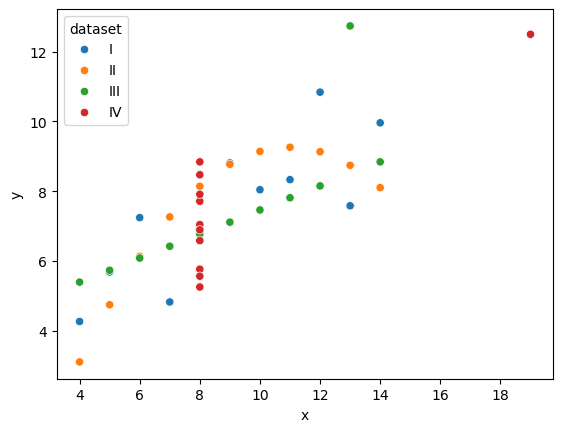

In [84]:
ans = sns.load_dataset('anscombe')
sns.scatterplot(data=ans, x='x', y='y', hue='dataset')

# Level Up: `statsmodels.formula.ols()`

There is an alternative way of using `statsmodels` to set up a linear regression, and that is with `sm.formula.ols()`:

In [85]:
sm.formula.ols(formula="y ~ x", data=test_df).fit().summary()

/Users/danielburdeno/miniconda3/envs/Cohort_Env/lib/python3.12/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/danielburdeno/miniconda3/envs/Cohort_Env/lib/python3.12/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/danielburdeno/miniconda3/envs/Cohort_Env/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1580: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/danielburdeno/miniconda3/envs/Cohor

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.067e+32
Date:                Thu, 17 Oct 2024   Prob (F-statistic):          2.05e-278
Time:                        16:33:57   Log-Likelihood:                 623.18
No. Observations:                  20   AIC:                            -1242.
Df Residuals:                      18   BIC:                            -1240.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0000   3.23e-15   1.55e+15      0.000       5.000       5.000
x              3.0000    2.9e-16   1.03e+16      0.000       3.000       3.000
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         21.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice that this way of doing things *automatically sets up an intercept column*.

That's an advantage, but this method has drawbacks inasmuch as the value for the `data` parameter has to have a certain structure. And in fact, once we start using train-test splits, our data will often *fail* to have that requisite structure.

# Level Up: Adjusted $R^2$

There are some theoretical [objections](https://data.library.virginia.edu/is-r-squared-useless/) to using $R^2$ as an evaluator of a regression model.

One objection is that, if we add another predictor to our model, $R^2$ can only *increase*! (It could hardly be that with more features I'd be able to account for *less* of the variation in the dependent variable than I could with the smaller set of features.)

One improvement is **adjusted $R^2$**: <br/> $\Large R^2_{adj.}\equiv 1 - \frac{(1 - R^2)(n - 1)}{n - m - 1}$, where:

- n is the number of data points; and
- m is the number of predictors.

This can be a better indicator of the quality of a regression model.

Note that Adjusted $R^2$ *can* be negative!